# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
# =========================================================================== #
# STANDARD IMPORTS
# =========================================================================== #
print(__doc__)

# Critical Imports
# --------------------------------------------------------------------------- #
import warnings; warnings.filterwarnings("ignore")

# Imports through 'from' syntax
# --------------------------------------------------------------------------- #
from pprint import pprint
from itertools import islice
from os import listdir; from os.path import isfile, join
# Standard Imports
# --------------------------------------------------------------------------- #
import copy; import os
import sys; import time
import itertools
import sklearn

# Imports through 'as' syntax
# --------------------------------------------------------------------------- #
import numpy as np; import pandas as pd

# Imports for handling graphics
# --------------------------------------------------------------------------- #
%matplotlib inline
# Matplotlib pyplot provides plotting API
import matplotlib as mpl
from matplotlib import pyplot as plt
import chart_studio.plotly.plotly as py
import seaborn as sns;  sns.set(style="ticks", color_codes=True) # sns.set()

Automatically created module for IPython interactive environment


In [2]:
# =========================================================================== #
# UTILS IMPORTS (Done by myself)
# =========================================================================== #
from utils.load_dataset_pittsburg_utils import load_brdiges_dataset; from utils.display_utils import *
from utils.preprocessing_utils import *; from utils.training_utils import *
from utils.sklearn_functions_custom import *; from utils.learning_curves_custom import *
from utils.training_utils_v2 import fit_by_n_components, fit_all_by_n_components, grid_search_all_by_n_components

In [3]:
# =========================================================================== #
# sklearn IMPORT
# =========================================================================== #
from sklearn.decomposition import PCA, KernelPCA

# Import scikit-learn classes: models (Estimators).
from sklearn.naive_bayes import GaussianNB, MultinomialNB   # Non-parametric Generative Model
from sklearn.linear_model import LogisticRegression         # Parametric Linear Discriminative Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC                          # Parametric Linear Discriminative "Support Vector Classifier"
from sklearn.tree import DecisionTreeClassifier      # Non-parametric Model
from sklearn.ensemble import RandomForestClassifier  # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)

In [4]:
# =========================================================================== #
# READ INPUT DATASET
# =========================================================================== #

dataset_path = 'C:\\Users\\Francesco\Documents\\datasets\\pittsburgh_dataset'
dataset_name = 'bridges.data.csv'

TARGET_COL = 'T-OR-D'  # Target variable name
dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

In [5]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [6]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #

columns = dataset.columns  # List of all attribute names

# Get Target values and map to 0s and 1s
# y = np.array(list(map(lambda x: 0 if x == 1 else 1, dataset[TARGET_COL].values)))
y = np.array(list(map(lambda x: -1 if x == 1 else 1, dataset[TARGET_COL].values)))
print('Summary about Target Variable {target_col}')
print('-' * 50)
print(dataset[TARGET_COL].value_counts())

# Get Predictors
X = dataset.loc[:, dataset.columns != TARGET_COL].values

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64


In [7]:
# Standardizing the features
# --------------------------------------------------------------------------- #
scaler_methods = ['minmax', 'standard', 'norm']
scaler_method = 'standard'
rescaledX = preprocessing_data_rescaling(scaler_method, X)

shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [8]:
n_components = rescaledX.shape[1]
pca = PCA(n_components=n_components)
# pca = PCA(n_components=2)

# X_pca = pca.fit_transform(X)
pca = pca.fit(rescaledX)
X_pca = pca.transform(rescaledX)

In [9]:
print(f"Cumulative varation explained(percentage) up to given number of pcs:")

tmp_data = []
principal_components = [pc for pc in '2,5,6,7,8,9,10'.split(',')]
for _, pc in enumerate(principal_components):
    n_components = int(pc)
    
    cum_var_exp_up_to_n_pcs = np.cumsum(pca.explained_variance_ratio_)[n_components-1]
    # print(f"Cumulative varation explained up to {n_components} pcs = {cum_var_exp_up_to_n_pcs}")
    # print(f"# pcs {n_components}: {cum_var_exp_up_to_n_pcs*100:.2f}%")
    tmp_data.append([n_components, cum_var_exp_up_to_n_pcs * 100])

tmp_df = pd.DataFrame(data=tmp_data, columns=['# PCS', 'Cumulative Varation Explained (percentage)'])
tmp_df.head(len(tmp_data))

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA



## Learning Models <a class="anchor" id="learning-models"></a>

In [10]:
# Parameters to be tested for Cross-Validation Approach

estimators_list = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
estimators_names = ['GaussianNB', 'LogRegr', 'Knn', 'SGD', 'SVC', 'DecisionTree', 'RandomForest']
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))

pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = [10, 9, 8, 7, 6, 5, 4, 3, 2]

parmas_logistic_regression = {
    'penalty': ('l1', 'l2', 'elastic', None),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'class_weight': (None, 'balanced'),
    'C': (10.0, 1.0, .1, .01, .001, .0001),
    'random_state': (0,),
}


parmas_knn_forest = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'minkowski', 'manhattan'),
    'leaf_size': (5, 10, 15, 30),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
}

parameters_sgd_classifier = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6)
}

kernel_type = 'svm-rbf-kernel'
parameters_svm = {
    # 'gamma': (.003, .03, .05, .5, .7, 1.0, 1.5, 10.0, 15.0),
    # 'gamma': (1e-7, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3, 1e+5, 1e+7),
    # 'gamma': (.003, .03, .05, .5, .7, 1.0, 1.5),
    # 'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    # 'penalty': ('l2','l1'),
    # 'degree': (1,2,3,4,5,6,7,8,9,10),
    # 'degree': (1,2,3,4),
    # 'coef0': (.001, .01, .1, 0.0, 1.0, 10.0),
    # 'shrinking': (True, False),
    # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'class_weight': (None, 'balanced'),
    # 'C': (1e-7, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3, 1e+5, 1e+7),
    'probability': (True,), 
}

parmas_decision_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'auto', 'sqrt', 'log2')
}

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False)
}

param_grids = [parmas_logistic_regression, parmas_knn_forest, parameters_sgd_classifier, parameters_svm, parmas_decision_tree, parmas_random_forest]

N_CV, N_KERNEL, N_GS = 9, 4, 6

In [11]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='accuracy',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}"), ignore_func=True,
    # figsize=(20,5)
)

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Kernel PCA: Linear | SVC
[*] Best Score:
0.8642857142857142


The best parameters are {'C': 1000.0, 'gamma': 0.001} with a score of 0.90


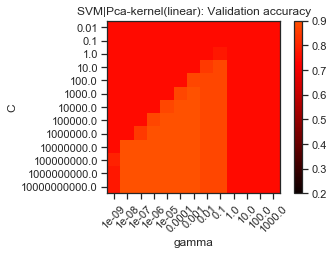

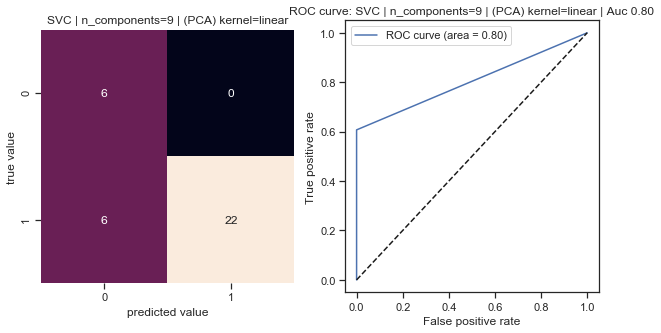

Kernel PCA: Poly | SVC
[*] Best Score:
0.8642857142857142


The best parameters are {'C': 10000000.0, 'gamma': 1e-06} with a score of 0.93


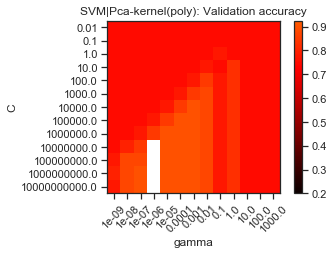

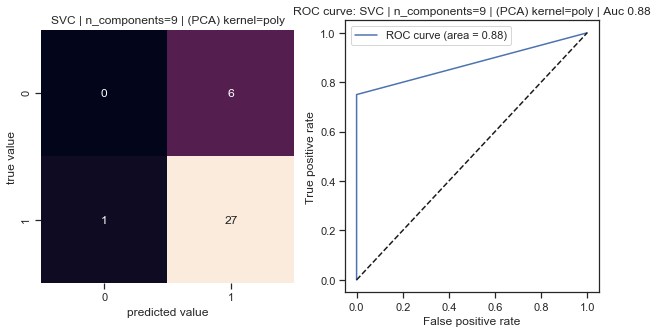

Kernel PCA: Rbf | SVC
[*] Best Score:
0.8928571428571429


The best parameters are {'C': 100.0, 'gamma': 1.0} with a score of 0.90


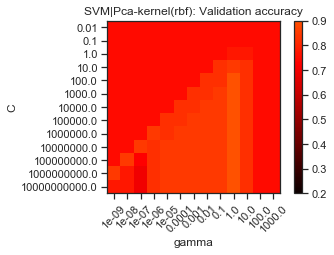

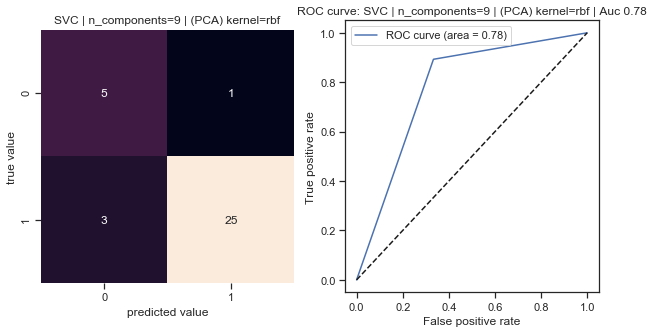

Kernel PCA: Cosine | SVC
[*] Best Score:
0.8642857142857142


The best parameters are {'C': 1000000000.0, 'gamma': 1e-07} with a score of 0.95


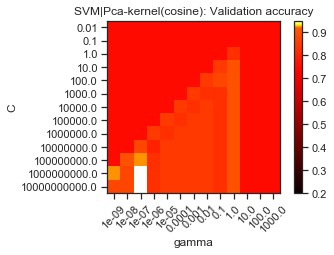

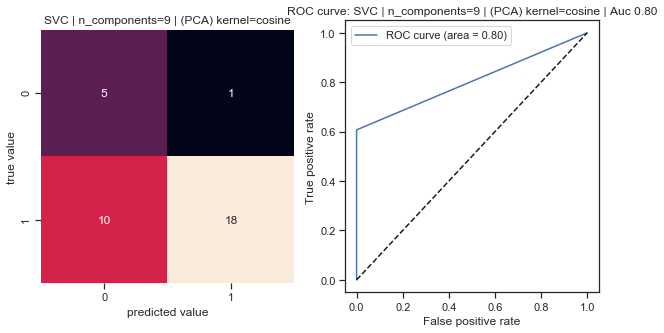

Kernel PCA: Sigmoid | SVC
[*] Best Score:
0.8642857142857142


The best parameters are {'C': 100.0, 'gamma': 1.0} with a score of 0.93


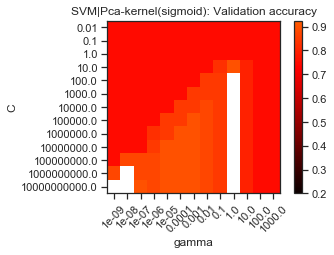

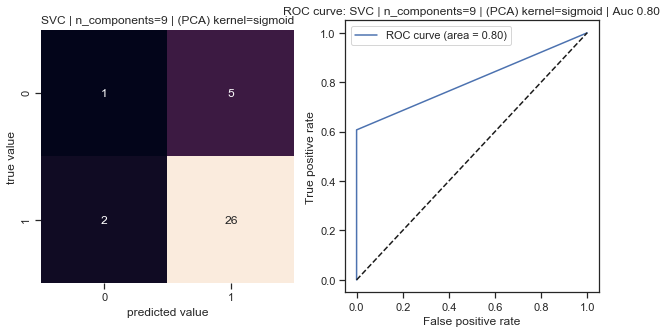

In [13]:
plot_dest = os.path.join("figures", "n_comp_9_analysis", "grid_search")
X = rescaledX

df_gs, df_auc_gs = grid_search_all_by_n_components(
    estimators_list=estimators_list[4], \
    param_grids=param_grids[3],
    estimators_names=estimators_names[4], \
    X=X, y=y,
    n_components=9,
    random_state=0, show_plots=False, show_errors=True, verbose=1, plot_dest=plot_dest, debug_var=False, flag_no_computation=False)
df_9, df_9_auc = df_gs, df_auc_gs

Looking at the results obtained running *Knn Classifier* against our dataset splitted into training set and test set and adopting a different kernel trick applied to *kernel-Pca* unsupervised preprocessing method we can state generally speaking that all the such a *Statistical Learning technique* leads to a sequence of results that on average are more than appreciable beacues of the accuracy scores obtained at test time which compared against the same score but related to train phase allows us to understand that during the model creation the resulting classifiers do not overfit to the data, and even when the training score was high it was still lower than the scores in terms of accuracy obtained from the Logisti Regression Models which overfit to the data. Moreover, looking at the weighted values of *Recall, Precision, and F1-Scores* we can notably claim that the classifiers based on Knn obtained good performance and and except for one trial where we got lower and worst results, when *Sigmoid Trick* is selected, in the remaning cases have gotten remarkable results. More precisely we can say what follows:
- speaking about __Linear kernel Pca based Knn Classifier__, when adoping the default threshold of *.5* for classification purposes we have a model that reaches an accuracy of *71%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *76%* with a Roc Curve that shows a behavior for which the model...

- observing __Polynomial kernel Pca based Knn Estimator__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *74%* at test time against an accuracy of *89%* at train step, while the Auc score reaches a value of *77%*...

- review __Rbf kernel Pca based Knn Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *79%* at test time against an accuracy of *95%* at train step, while the Auc score reaches a value of *74%*...

- looking at __Cosine kernel Pca based Knn Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *59%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *62%*...

- finally, referring to __Sigmoid kernel Pca based Knn Model__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *65%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *72%*...

In [14]:
create_widget_list_df([df_gs, df_auc_gs]) #print(df_gs); print(df_auc_gs)

Looking at the table dispalyed just above that shows the details about the selected values for hyper-parameters specified during grid search, in the different situations accordingly to the fixed kernel-trick for kernel Pca unsupervised method we can state that, referring to the first two columns of *Train and Test Accuracy*, we can recognize which trials lead to more overfit results such as for *Linear, Polynomial, and Sigmoid Tricks* or less overfit solution such as in the case of *Cosine, Trick*. Speaking about the hyper-parameters, we can say what follows:

- referring to the svm's __Gamma Parameter__, which we recall that corresponds normally to *Kernel Coefficient* for *rbf, poly and sigmoid reprojection strategies*, we also remind that intuitively, the gamma parameter defines how far the influence of a single training example reaches, with *low values* meaning *far* and *high values* meaning *close*. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

- looking at svm's __C Parameter__, and suggesting that such a parameter briefly trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. So that, a lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words ``C`` behaves as a regularization parameter in the SVM.

- instead, when speaking about svm's __Degree Parameter__, which is degree of the *polynomial kernel function (poly)*, therefore ignored by all other kernels, we are talking about a niche hyper-params that usually taking larger values implyes attempting to fit models that tends to lower bias values and higher variance, instead taking into account lower polynomial order my bit on higher bias and lower variance models. In other words, in one case we attempt to explain with a more fancy model a problem that might not follow a linear and smooth trend, vice versa, in the second case we prefer to represent our model by means of a lower capaciy classifier, easier to explain and understand.
- considering svm's __coef0 Parameter__, which is Independent term in kernel function. It is only significant in svm kernel tricks' *poly and sigmoid* ...

- the svm's __Shrinking Parameter__, from research field we found that if the number of iterations is large, then shrinking can shorten the training time...

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

### References  <a class="anchor" id="references"></a>
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (SVM) https://scikit-learn.org/stable/modules/svm.html
    - (PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Markdown Math part:
    - https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html
    
#### others
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Third Party Library:
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
- KDE:
    - (TUTORIAL) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c